In [1]:
!pip install Cmake

In [2]:
!pip install tensorflow opencv-python albumentations matplotlib

In [3]:
!pip install tensorflow-cpu

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt

In [5]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [8]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[181, 184, 177],
        [183, 186, 179],
        [181, 186, 179],
        ...,
        [198, 205, 198],
        [199, 206, 199],
        [198, 205, 198]],

       [[180, 183, 176],
        [183, 186, 179],
        [181, 186, 179],
        ...,
        [198, 205, 198],
        [199, 206, 199],
        [199, 206, 199]],

       [[180, 183, 176],
        [183, 186, 179],
        [181, 186, 179],
        ...,
        [199, 206, 199],
        [199, 206, 199],
        [197, 204, 197]],

       ...,

       [[ 67,  64,  57],
        [ 68,  65,  58],
        [ 69,  66,  59],
        ...,
        [ 13,  58,  37],
        [ 14,  59,  39],
        [ 15,  60,  40]],

       [[ 65,  62,  55],
        [ 64,  61,  54],
        [ 67,  64,  57],
        ...,
        [ 11,  56,  35],
        [ 11,  56,  36],
        [ 10,  55,  35]],

       [[ 64,  61,  54],
        [ 61,  58,  51],
        [ 65,  62,  55],
        ...,
        [  5,  50,  29],
        [  8,  53,  33],
        [ 13,  58,  38]]

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

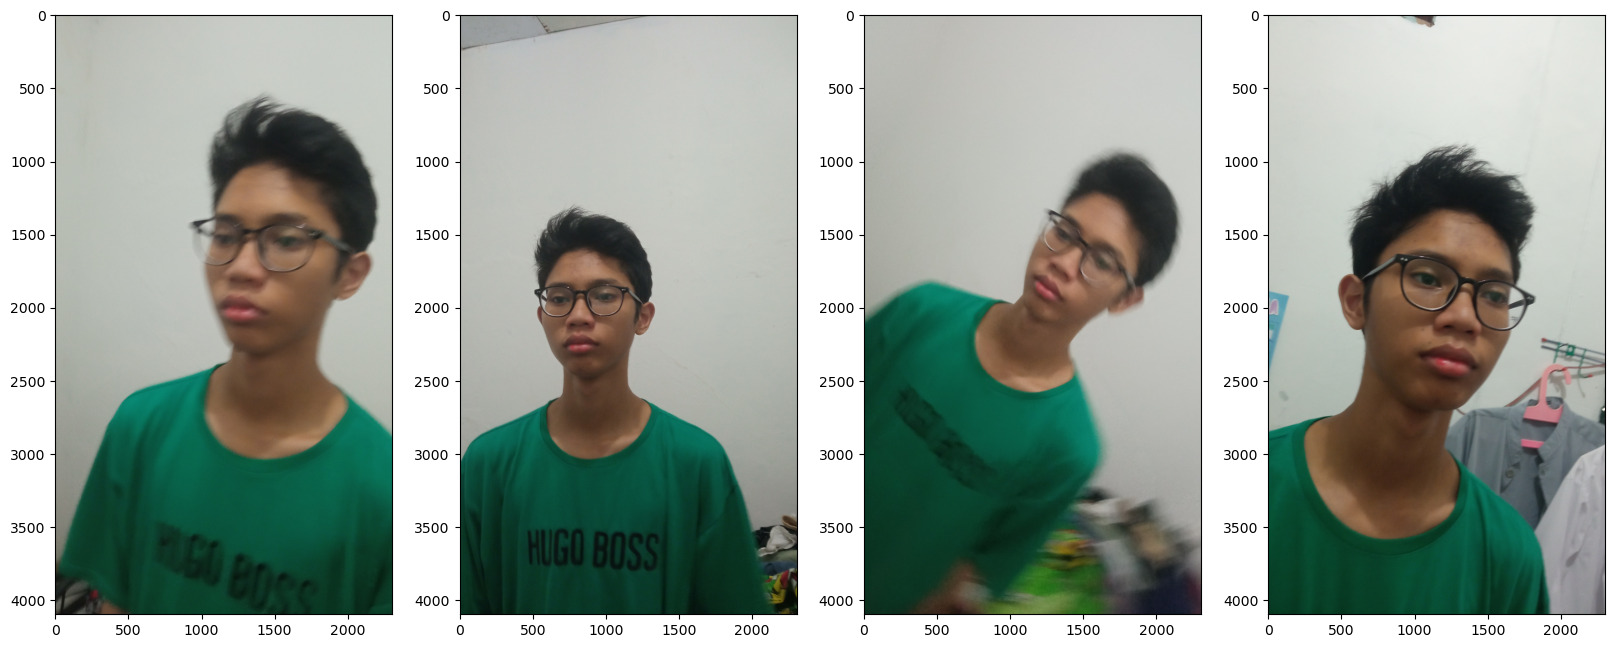

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [16]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=1728, height=1728),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.VerticalFlip(p=0.5),
                        alb.RGBShift(p=0.2)],
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [19]:
img = cv2.imread(os.path.join('data','train', 'images', '1685344290795.jpg'))

In [20]:
with open(os.path.join('data','train','labels', '1685344290795.json'), 'r') as f:
    label = json.load(f)

In [21]:
label['shapes'][0]['points']

[[784.3529411764707, 730.3529411764707],
 [2284.3529411764707, 2471.529411764706]]

In [22]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [23]:
img.shape

(4096, 2304, 3)

In [24]:
coords = list(np.divide(coords, [2304, 4096, 2304, 4096]))

In [25]:
coords

[0.3404309640522876,
 0.1783088235294118,
 0.9914726307189543,
 0.6034007352941176]

In [26]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [27]:
augmented['image'].shape

(1728, 1728, 3)

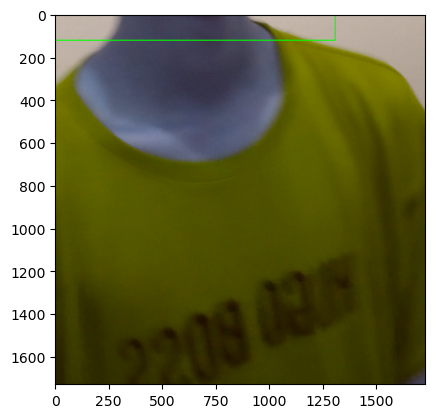

In [28]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1728, 1728]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [1728, 1728]).astype(int)),
                        (0,255,0), 3)
plt.imshow(augmented['image'])

In [31]:
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [2304, 4096, 2304, 4096]))
            
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0, 0, 0, 0, 'face'].
x_max is less than or equal to x_min for bbox [0, 0, 0, 0, 'face'].
x_max is less than or equal to x_min for bbox [0.6359540343915344, 0.21358816964285712, -9.868649107779169e-17, 0.7595302483974359, 'face'].
x_max is less than or equal to x_min for bbox [0.8408394607843138, 0.7010569852941176, 0.3123468137254901, 0.27022058823529416, 'face'].
x_max is less than or equal to x_min for bbox [0, 0, 0, 0, 'face'].
x_max is less than or equal to x_min for bbox [0.8536049836601306, 0.5057444852941176, 0.22296772875816984, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0, 0, 0, 0, 'face'].
x_max is less than or equal to x_min for bbox [0.3156001984126984, 0.10895647321428568, -4.9343245538895844e-17, 0.5912172042112299, 'face'].
x_max is less than or equal to x_min for bbox [0.580150462962963, 0.1821986607142857, 0.0572503306878307, 0.5786365327380952, 'face'].
x_max is less than or equal to x_min for bbox [0.62

In [32]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda img: tf.image.resize(img, (256,256)))
train_images = train_images.map(lambda img: img/255)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda img: tf.image.resize(img, (256,256)))
val_images = val_images.map(lambda img: img/255)

In [34]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda img: tf.image.resize(img, (256,256)))
test_images = test_images.map(lambda img: img/255)

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [37]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

# # Combine Label and Image Samples

In [43]:
len(train_images), len(val_images), len(test_images)

(3300, 780, 600)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(7).prefetch(4)

In [45]:
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(1200).batch(7).prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000).batch(7).prefetch(4)

In [47]:
train.as_numpy_iterator().next()[0].shape

(7, 256, 256, 3)

In [48]:
data_samples = train.as_numpy_iterator()

In [105]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


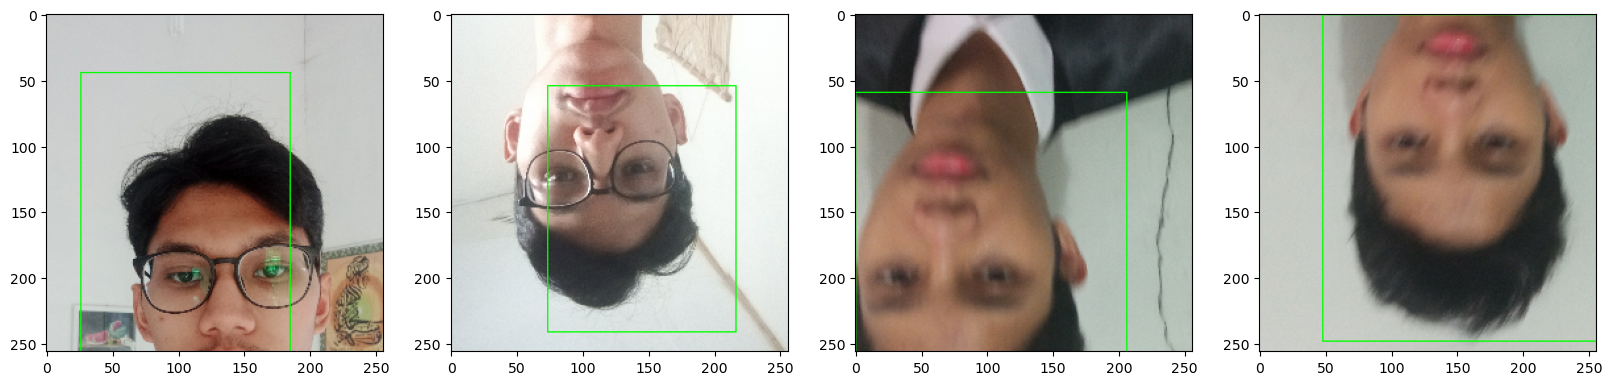

In [106]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    sample_image = res[0][i]
    sample_coords = res[1][1][i]
    
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [256,256]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [256, 256]).astype(int)),
                 (0,255,0), 1)
    
    ax[i].imshow(sample_image)

# Neural Network

In [107]:
vgg = tf.keras.applications.VGG16(include_top=False)

In [108]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [109]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(256,256,3))
    
    vgg = tf.keras.applications.VGG16(include_top=False)(input_layer)
    
    f1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    clas_1 = tf.keras.layers.Dense(2048, activation='relu')(f1)
    clas_2 = tf.keras.layers.Dense(1, activation='sigmoid')(clas_1)
    
    f2 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    reg_1 = tf.keras.layers.Dense(2048, activation='relu')(f2)
    reg_2 = tf.keras.layers.Dense(4, activation='sigmoid')(reg_1)
    
    facedetector = tf.keras.models.Model(inputs=input_layer, outputs=[clas_2, reg_2])
    return facedetector

In [110]:
facedetector = build_model()

In [111]:
facedetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [112]:
X, y = train.as_numpy_iterator().next()

In [113]:
X.shape

(7, 256, 256, 3)

In [114]:
classes, coords = facedetector.predict(X)

1/1 [==============================] - 17s 17s/step


In [115]:
classes, coords

(array([[0.7540166 ],
        [0.77521384],
        [0.75659394],
        [0.81201243],
        [0.8225385 ],
        [0.7908379 ],
        [0.7549735 ]], dtype=float32),
 array([[0.4130285 , 0.42781153, 0.5660109 , 0.5291698 ],
        [0.46939632, 0.44394058, 0.63368165, 0.5695197 ],
        [0.48536232, 0.38628647, 0.55381984, 0.4996816 ],
        [0.5220408 , 0.46354017, 0.65493065, 0.44866633],
        [0.60609084, 0.4468146 , 0.65034145, 0.5343171 ],
        [0.5123402 , 0.41175735, 0.60471916, 0.56159145],
        [0.5378801 , 0.3774113 , 0.6598639 , 0.6206825 ]], dtype=float32))